<a href="https://colab.research.google.com/github/Its-suLav-D/CSE450/blob/main/book_publishing_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

## I. Parse Text Sources
First we'll load our text sources and create our vocabulary lists and encoders. 

There are ways we could do this in pure python, but using the tensorflow data structures and libraries allow us to keep things super-optimized.

In [ ]:
# Load file data
path_to_file = tf.keras.utils.get_file('dickens.txt', 'https://www.gutenberg.org/cache/epub/730/pg730.txt')
text = open(path_to_file, 'rb').read()[6365:].decode(encoding='utf-8')
print('Length of text: {} characters'.format(len(text)))

955784/955784 [==============================] - 1s 1us/step
Length of text: 925179 characters


In [ ]:
# Verify the first part of our data
print(text[:200])




 CHAPTER I.
TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN AND OF THE
CIRCUMSTANCES ATTENDING HIS BIRTH


Among other public buildings in a certain town, which for many reasons
it will be 


In [ ]:
# Now we'll get a list of the unique characters in the file. This will form the
# vocabulary of our network. There may be some characters we want to remove from this 
# set as we refine the network.
vocab = sorted(set(text))
vocab.remove("_")
print('{} unique characters'.format(len(vocab)))
print(vocab)

88 unique characters
['\n', '\r', ' ', '!', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”', '•', '™']


In [ ]:
# Next, we'll encode encode these characters into numbers so we can use them
# with our neural network, then we'll create some mappings between the characters
# and their numeric representations
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True)

# Here's a little helper function that we can use to turn a sequence of ids
# back into a string:
# turn them into a string:
def text_from_ids(ids):
  joinedTensor = tf.strings.reduce_join(chars_from_ids(ids), axis=-1)
  return joinedTensor.numpy().decode("utf-8")

In [ ]:
# Now we'll verify that they work, by getting the code for "A", and then looking
# that up in reverse
testids = ids_from_chars(["T", "r", "u", "t", "h"])
testids

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([47, 73, 76, 75, 63])>

In [ ]:
chars_from_ids(testids)

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'T', b'r', b'u', b't', b'h'], dtype=object)>

In [ ]:
testString = text_from_ids( testids )
testString

'Truth'

## II. Construct our training data
Next we need to construct our training data by building sentence chunks. Each chunk will consist of a sequence of characters and a corresponding "next sequence" of the same length showing what would happen if we move forward in the text. This "next sequence" becomes our target variable.

For example, if this were our text:

> It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

And our sequence length was 10 with a step size of 1, our first chunk would be:

* Sequence: `It is a tr`
* Next Sequence: `t is a tru`

Our second chunk would be:

* Sequence: `t is a tru`
* Next Word: ` is a trut`



In [ ]:
# First, create a stream of encoded integers from our text
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(925179,), dtype=int64, numpy=array([1, 2, 1, ..., 1, 2, 1])>

In [ ]:
# Now, convert that into a tensorflow dataset
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
# Finally, let's batch these sequences up into chunks for our training
seq_length = 150
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# This function will generate our sequence pairs:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

# Call the function for every sequence in our list to create a new dataset
# of input->target pairs
dataset = sequences.map(split_input_target)

In [ ]:
# Verify our sequences
for input_example, target_example in  dataset.take(1):
    print("Input: ", text_from_ids(input_example))
    print("--------")
    print("Target: ", text_from_ids(target_example))

Input:  


 CHAPTER I.
TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN AND OF THE
CIRCUMSTANCES ATTENDING HIS BIRTH


Among other public buildings in a
--------
Target:  

 CHAPTER I.
TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN AND OF THE
CIRCUMSTANCES ATTENDING HIS BIRTH


Among other public buildings in a 


In [ ]:
# Finally, we'll randomize the sequences so that we don't just memorize the books
# in the order they were written, then build a new streaming dataset from that.
# Using a streaming dataset allows us to pass the data to our network bit by bit,
# rather than keeping it all in memory. We'll set it to figure out how much data
# to prefetch in the background.

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 150), dtype=tf.int64, name=None), TensorSpec(shape=(64, 150), dtype=tf.int64, name=None))>

## III. Build the model

Next, we'll build our model. Up until this point, you've been using the Keras symbolic, or imperative API for creating your models. Doing something like:

    model = tf.keras.models.Sequentla()
    model.add(tf.keras.layers.Dense(80, activation='relu))
    etc...

However, tensorflow has another way to build models called the Functional API, which gives us a lot more control over what happens inside the model. You can read more about [the differences and when to use each here](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html).

We'll use the functional API for our RNN in this example. This will involve defining our model as a custom subclass of `tf.keras.Model`.

If you're not familiar with classes in python, you might want to review [this quick tutorial](https://www.w3schools.com/python/python_classes.asp), as well as [this one on class inheritance](https://www.w3schools.com/python/python_inheritance.asp).

Using a functional model is important for our situation because we're not just training it to predict a single character for a single sequence, but as we make predictions with it, we need it to remember those predictions as use that memory as it makes new predictions.


In [ ]:
# Create our custom model. Given a sequence of characters, this
# model's job is to predict what character should come next.
class AustenTextModel(tf.keras.Model):

  # This is our class constructor method, it will be executed when
  # we first create an instance of the class 
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)

    # Our model will have three layers:
    
    # 1. An embedding layer that handles the encoding of our vocabulary into
    #    a vector of values suitable for a neural network
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # 2. A GRU layer that handles the "memory" aspects of our RNN. If you're
    #    wondering why we use GRU instead of LSTM, and whether LSTM is better,
    #    take a look at this article: https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm
    #    then consider trying out LSTM instead (or in addition to!)
    self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)

    # 3. Our output layer that will give us a set of probabilities for each
    #    character in our vocabulary.
    self.dense1 = tf.keras.layers.Dense(1024)
    self.dense2 = tf.keras.layers.Dense(512)
    self.dense = tf.keras.layers.Dense(vocab_size)

  # This function will be executed for each epoch of our training. Here
  # we will manually feed information from one layer of our network to the 
  # next.
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs

    # 1. Feed the inputs into the embedding layer, and tell it if we are
    #    training or predicting
    x = self.embedding(x, training=training)

    # 2. If we don't have any state in memory yet, get the initial random state
    #    from our GRUI layer.
    if states is None:
      states = self.gru.get_initial_state(x)
    
    # 3. Now, feed the vectorized input along with the current state of memory
    #    into the gru layer.
    x, states = self.gru(x, initial_state=states, training=training)

    # 4. Finally, pass the results on to the dense layer
    x= self.dense1(x, training=training)
    x= self.dense2(x, training=training)
    x = self.dense(x, training=training)

    # 5. Return the results
    if return_state:
      return x, states
    else: 
      return x

In [ ]:
# Create an instance of our model
vocab_size=len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

model = AustenTextModel(vocab_size, embedding_dim, rnn_units)

In [ ]:
# Verify the output of our model is correct by running one sample through
# This will also compile the model for us. This step will take a bit.
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 150, 89) # (batch_size, sequence_length, vocab_size)


In [ ]:
# Now let's view the model summary
model.summary()

Model: "austen_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  22784     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  1049600   
                                                                 
 dense_1 (Dense)             multiple                  524800    
                                                                 
 dense_2 (Dense)             multiple                  45657     
                                                                 
Total params: 5,581,145
Trainable params: 5,581,145
Non-trainable params: 0
_________________________________________________________________


## IV. Train the model

For our purposes, we'll be using [categorical cross entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) as our loss function*. Also, our model will be outputting ["logits" rather than normalized probabilities](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow), because we'll be doing further transformations on the output later. 


\* Note that since our model deals with integer encoding rather than one-hot encoding, we'll specifically be using [sparse categorical cross entropy](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other).

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

history = model.fit(dataset, epochs=50)

Epoch 1/50
95/95 [==============================] - 16s 110ms/step - loss: 2.6358
Epoch 2/50
95/95 [==============================] - 11s 103ms/step - loss: 2.0131
Epoch 3/50
95/95 [==============================] - 11s 105ms/step - loss: 1.7681
Epoch 4/50
95/95 [==============================] - 11s 104ms/step - loss: 1.6150
Epoch 5/50
95/95 [==============================] - 12s 107ms/step - loss: 1.5028
Epoch 6/50
95/95 [==============================] - 12s 110ms/step - loss: 1.4216
Epoch 7/50
95/95 [==============================] - 12s 111ms/step - loss: 1.3552
Epoch 8/50
95/95 [==============================] - 12s 110ms/step - loss: 1.2998
Epoch 9/50
95/95 [==============================] - 12s 109ms/step - loss: 1.2488
Epoch 10/50
95/95 [==============================] - 12s 114ms/step - loss: 1.1997
Epoch 11/50
95/95 [==============================] - 12s 111ms/step - loss: 1.1544
Epoch 12/50
95/95 [==============================] - 12s 109ms/step - loss: 1.1111
Epoch 13/50
9

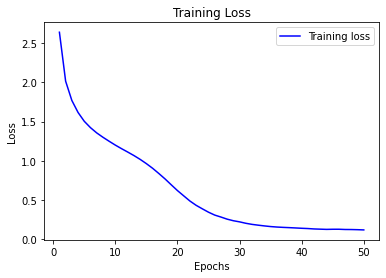

In [ ]:
import matplotlib.pyplot as plt

# Get training loss and accuracy values from the history object
loss = history.history['loss']


# Create the x-axis values (epochs)
epochs = range(1, len(loss) + 1)

# Plot training loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



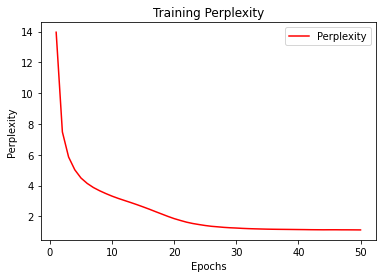

In [ ]:
import numpy as np

perplexity = np.exp(history.history['loss'])
plt.plot(epochs, perplexity, 'r', label='Perplexity')
plt.title('Training Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/bookpublish/dickens')

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow.keras as keras


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/bookpublish')

OSError: ignored

## V. Use the model

Now that our model has been trained, we can use it to generate text. As mentioned earlier, to do so we have to keep track of its internal state, or memory, so that we can use previous text predictions to inform later ones.

However, with RNN generated text, if we always just pick the character with the highest probability, our model tends to get stuck in a loop. So instead we will create a probability distribution of characters for each step, and then sample from that distribution. We can add some variation to this using a paramter known as ["temperature"](https://cs.stackexchange.com/questions/79241/what-is-temperature-in-lstm-and-neural-networks-generally).

In [ ]:
# Here's the code we'll use to sample for us. It has some extra steps to apply
# the temperature to the distribution, and to make sure we don't get empty
# characters in our text. Most importantly, it will keep track of our model
# state for us.

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.2):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask,validate_indices=False)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Return the characters and model state.
    return chars_from_ids(predicted_ids), states


In [ ]:
# Create an instance of the character generator
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

# Now, let's generate a 1000 character chapter by giving our model "Chapter 1"
# as its starting text
states = None
next_char = tf.constant(['CHAPTER I'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)

# Print the results formatted.
print(result[0].numpy().decode('utf-8'))




CHAPTER I.
TOEVER BETTER ACQUAINTEST WHEN HASTER BETWEEN HARRY, ED.AHLED ANYOLION SHEARS A SUBDEN COSLECEMES OF MERCHAMEN BY FAGIN, A very
Oliver had expectation, as fasiness at the medge of his right angles; and wrenching his
hands tighter and tighter in the garments of all in singar:
and enableed in the heavy manner, that Oliver was on his turpound load, had
entered the shop without attracting the door, and looking
refreshing to Mr. Brothles, shall in it. Some happiness, the Project
Gutenberg Literary Archive Foundation, the manager of the 
letter courc around the door. Brittles obeyed; the girl’s life and half-headed or fiftient; and
then, although he could hear it was the boy and his young comrade
sat in a corner by themselves, without being much troubled by their
company.

They had some cold meat for dinner, and sat himself downstairs to the eye, the expression of steenny
fumiating, stepped up the stairs inchint for his drast with the hands of
his hands into his pockets, and


## VI. Next Steps

This is a very simple model with one GRU layer and then an output layer. However, considering how simple it is and the fact that we are predicting outputs character by character, the text it produces is pretty amazing. Though it still has a long way to go before publication.

There are many other RNN architectures you could try, such as adding additional hidden dense layers, replacing GRU with one or more LSTM layers, combining GRU and LSTM, etc...

You could also experiment with better text cleanup to make sure odd punctuation doesn't appear, or finding longer texts to use. If you combine texts from two authors, what happens? Can you generate a Jane Austen stageplay by combining austen and shakespeare texts?

Finally, there are a number of hyperparameters to tweak, such as temperature, epochs, batch size, sequence length, etc...

In [ ]:
!pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.translate.bleu_score import sentence_bleu


In [ ]:
generated_text="""TOEVER BETTER ACQUAINTEST WHEN HASTER BETWEEN HARRY, ED.AHLED ANYOLION SHEARS A SUBDEN COSLECEMES OF MERCHAMEN BY FAGIN, A very Oliver had expectation, as fasiness at the medge of his right angles; and wrenching his
hands tighter and tighter in the garments of all in singar:
and enableed in the heavy manner, that Oliver was on his turpound load, had
entered the shop without attracting the door, and looking
refreshing to Mr. Brothles, shall in it. Some happiness, the Project
Gutenberg Literary Archive Foundation, the manager of the 
letter courc around the door. Brittles obeyed; the girl’s life and half-headed or fiftient; and
then, although he could hear it was the boy and his young comrade
sat in a corner by themselves, without being much troubled by their
company.

They had some cold meat for dinner, and sat himself downstairs to the eye, the expression of steenny
fumiating, stepped up the stairs inchint for his drast with the hands of
his hands into his pockets, and"""

reference_text = """ TREATS OF THE PLACE WHERE OLIVER TWIST WAS BORN AND OF THE
CIRCUMSTANCES ATTENDING HIS BIRTH


Among other public buildings in a certain town, which for many reasons
it will be prudent to refrain from mentioning, and to which I will
assign no fictitious name, there is one anciently common to most towns,
great or small: to wit, a workhouse; and in this workhouse was born; on
a day and date which I need not trouble myself to repeat, inasmuch as
it can be of no possible consequence to the reader, in this stage of
the business at all events; the item of mortality whose name is
prefixed to the head of this chapter.

For a long time after it was ushered into this world of sorrow and
trouble, by the parish surgeon, it remained a matter of considerable
doubt whether the child would survive to bear any name at all; in which
case it is somewhat more than probable that these memoirs would never
have appeared; or, if they had, that being comprised within a couple of
pages, they would have possessed the inestimable merit of being the
most concise and faithful specimen of biography, extant in the
literature of any age or country.

Although I am not disposed to maintain that the being born in a
workhouse, is in itself the most fortunate and enviable circumstance
that can possibly befall a human being, I do mean to say that in this
particular instance, it was the best thing for Oliver Twist that could
by possibility have occurred. The fact is, that there was considerable
difficulty in inducing Oliver to take upon himself the office of
respiration,—a troublesome practice, but one which custom has rendered
necessary to our easy existence; and for some time he lay gasping on a
little flock mattress, rather unequally poised between this world and
the next: the balance being decidedly in favour of the latter. Now, if,
during this brief period, Oliver had been surrounded by careful
grandmothers, anxious aunts, experienced nurses, and doctors of
profound wisdom, he would most inevitably and indubitably have been
killed in no time. There being nobody by, however, but a pauper old
woman, who was rendered rather misty by an unwonted allowance of beer;
and a parish surgeon who did such matters by contract; Oliver and
Nature fought out the point between them. The result was, that, after a
few struggles, Oliver breathed, sneezed, and proceeded to advertise to
the inmates of the workhouse the fact of a new burden having been
imposed upon the parish, by setting up as loud a cry as could
reasonably have been expected from a male infant who had not been
possessed of that very useful appendage, a voice, for a much longer
space of time than three minutes and a quarter.

As Oliver gave this first proof of the free and proper action of his
lungs, the patchwork coverlet which was carelessly flung over the iron
bedstead, rustled; the pale face of a young woman was raised feebly
from the pillow; and a faint voice imperfectly articulated the words,
“Let me see the child, and die.”

The surgeon had been sitting with his face turned towards the fire:
giving the palms of his hands a warm and a rub alternately. As the
young woman spoke, he rose, and advancing to the bed’s head, said, with
more kindness than might have been expected of him:

“Oh, you must not talk about dying yet.”

“Lor bless her dear heart, no!” interposed the nurse, hastily
depositing in her pocket a green glass bottle, the contents of which
she had been tasting in a corner with evident satisfaction.

“Lor bless her dear heart, when she has lived as long as I have, sir,
and had thirteen children of her own, and all on ’em dead except two,
and them in the wurkus with me, she’ll know better than to take on in
that way, bless her dear heart! Think what it is to be a mother,
there’s a dear young lamb do.”

Apparently this consolatory perspective of a mother’s prospects failed
in producing its due effect. The patient shook her head, and stretched
out her hand towards the child.

The surgeon deposited it in her arms. She imprinted her cold white lips
passionately on its forehead; passed her hands over her face; gazed
wildly round; shuddered; fell back—and died. They chafed her breast,
hands, and temples; but the blood had stopped forever. They talked of
hope and comfort. They had been strangers too long.

“It’s all over, Mrs. Thingummy!” said the surgeon at last.

“Ah, poor dear, so it is!” said the nurse, picking up the cork of the
green bottle, which had fallen out on the pillow, as she stooped to
take up the child. “Poor dear!”

“You needn’t mind sending up to me, if the child cries, nurse,” said
the surgeon, putting on his gloves with great deliberation. “It’s very
likely it _will_ be troublesome. Give it a little gruel if it is.” He
put on his hat, and, pausing by the bed-side on his way to the door,
added, “She was a good-looking girl, too; where did she come from?”

“She was brought here last night,” replied the old woman, “by the
overseer’s order. She was found lying in the street. She had walked
some distance, for her shoes were worn to pieces; but where she came
from, or where she was going to, nobody knows.”

The surgeon leaned over the body, and raised the left hand. “The old
story,” he said, shaking his head: “no wedding-ring, I see. Ah!
Good-night!”

The medical gentleman walked away to dinner; and the nurse, having once
more applied herself to the green bottle, sat down on a low chair
before the fire, and proceeded to dress the infant.

What an excellent example of the power of dress, young Oliver Twist
was! Wrapped in the blanket which had hitherto formed his only
covering, he might have been the child of a nobleman or a beggar; it
would have been hard for the haughtiest stranger to have assigned him
his proper station in society. But now that he was enveloped in the old
calico robes which had grown yellow in the same service, he was badged
and ticketed, and fell into his place at once—a parish child—the orphan
of a workhouse—the humble, half-starved drudge—to be cuffed and
buffeted through the world—despised by all, and pitied by none.

Oliver cried lustily. If he could have known that he was an orphan,
left to the tender mercies of church-wardens and overseers, perhaps he
would have cried the louder."""

# Tokenize the generated and reference texts
generated_tokens = generated_text.split()
reference_tokens = reference_text.split()

# Calculate the BLEU score
bleu_score = sentence_bleu([reference_tokens], generated_tokens)
print("BLEU score:", bleu_score)




BLEU score: 7.099636268284111e-81
